### Imports

In [38]:
from neuron import h, gui
from neuron.units import ms, mV
import matplotlib.pyplot as plt
import numpy as np
import math

### HH Model

In [39]:
GdNa = [40.3, 42.6, 46.8, 39.5, 38.2, 30.7, 20.0, 15.3, 7.9, 1.44, 0.13, 0.046]
Tm = [0.14, 0.16, 0.2, 0.189, 0.252, 0.318, 0.382, 0.520, 0.6, 0.4, 0.22, 0.2]
Th = [0.67, 0.67, 0.67, 0.84, 0.84, 1.06, 1.27, 1.33, 1.5, 2.3, 5.52, 6.73]
Voltage = [-109, -100, -88, -76, -63, -51, -38, -32, -26, -19, -10, -6]

def alpha_n(v):
    return (0.01*(v+10)/[math.exp((v+10)/10) - 1])

def beta_n(v):
    return (0.125*math.exp(v/80))

def alpha_m(v):
    return (0.1*(v+25)/[math.exp((v+25)/10) - 1])

def beta_m(v):
    return (4*math.exp(v/18))

def alpha_h(v):
    return (0.07 * math.exp(v/20))

def beta_h(v):
    return (1/(math.exp((v+30) / 10) + 1))

def n_inf(alpha_n, beta_n):
    return (alpha_n / (alpha_n + beta_n))

def m_inf(alpha_m, beta_m):
    return (alpha_m / (alpha_m + beta_m))

def h_inf(alpha_h, beta_h):
    return (alpha_h / (alpha_h + beta_h))

def GNa(GdNa, t, Tm, Th):
    return (GdNa * ((1 - math.exp(-t/Tm))**3) * math.exp(-t/Th))

Initialization:

In [40]:
alpha_n_ylist = []
beta_n_ylist = []
alpha_m_ylist = []
beta_m_ylist = []
alpha_h_ylist = []
beta_h_ylist = []

n_inf_ylist = []
m_inf_list = []
h_inf_list = []

### Ball and Stick Model

In [41]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.all = [self.soma, self.dend]
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite                       # <-- NEW
        self.dend.insert('pas')                                        # <-- NEW
        for seg in self.dend:                                          # <-- NEW
            seg.pas.g = 0.001  # Passive conductance in S/cm2          # <-- NEW
            seg.pas.e = -65    # Leak reversal potential mV            # <-- NEW 
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)
    
    def apply_vclamp(self, dur, amp, res):
        vclamp = h.SEClamp(0.5, sec=self.dend)
        vclamp.dur1 = dur  # duration of the voltage step (ms)
        vclamp.amp1 = amp  # amplitude of the voltage step (mV)
        vclamp.rs = res  # series resistance (ohm)
    
    def apply_iclamp(self, dur, amp):
        iclamp = h.IClamp(my_cell.dend(1))
        iclamp.dur = dur
        iclamp.amp = amp

my_cell = BallAndStick(0)

### Verification

The ball stick model spike

In [42]:
stim = h.IClamp(my_cell.dend(1))
stim.delay = 5
stim.dur = 1
stim.amp = 0.1

In [43]:
soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
# gk_vec = h.Vector().record(my_cell.soma(0.5).hh._ref_gk)
# n_vec = h.Vector().record(my_cell.soma(0.5).hh._ref_n)
t = h.Vector().record(h._ref_t)

In [44]:
h.finitialize(-65 * mV)
h.continuerun(50 * ms)

0.0

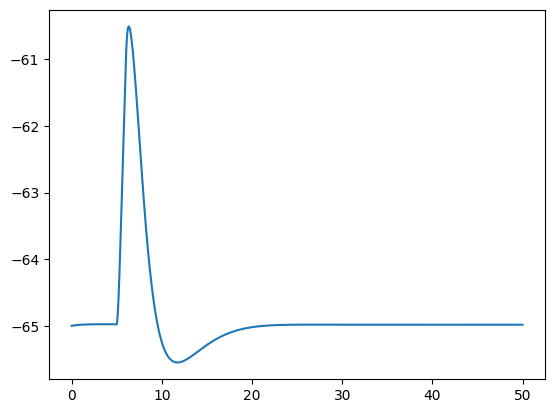

In [45]:
plt.plot(t,soma_v)
plt.show()

### Figure 2

Added a V Clamp and a depolization of 25mV

In [46]:
vclamp = h.VClamp(0.5, sec=my_cell.soma)
vclamp.dur[0] = 5  # duration of the voltage step (ms)
vclamp.amp[0] = -40  # amplitude of the voltage step (mV)

In [47]:
soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
gk_vec = h.Vector().record(my_cell.soma(0.5).hh._ref_gk)

In [48]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

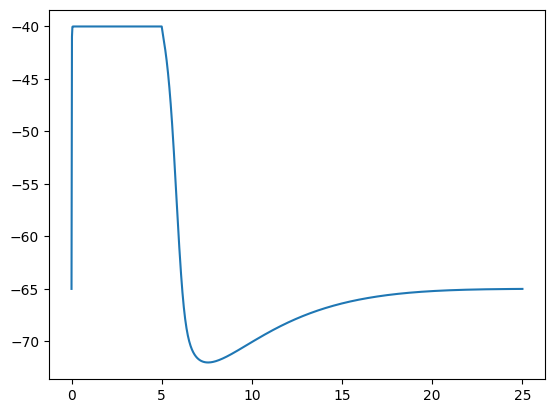

In [49]:
plt.plot(t,soma_v)
plt.show()

Depolrization successful

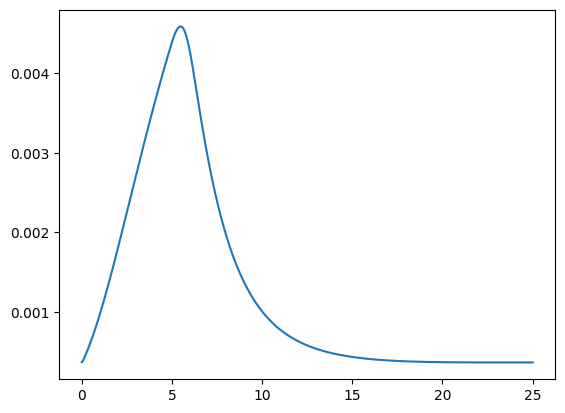

In [50]:
plt.plot(t,gk_vec)
#plt.xlim([0, 5])
plt.show()

Figure 2 Maybe

### Figure 3

In [51]:
v_arr = [-59,-55,-46,-39,-33,-27,-14,-2,11,23,35,44]
vclamp = h.VClamp(0.5, sec=my_cell.soma)
vclamp.dur[0] = 11  # duration of the voltage step (ms)

h.finitialize(-65 * mV)
h.continuerun(11 * ms)
gk_arr = h.Vector()

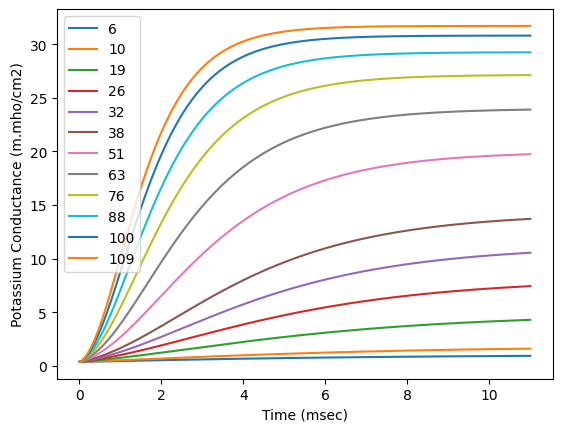

In [52]:
for v in v_arr:  
  vclamp.amp[0] = v # amplitude of the voltage step (mV)
  gk_vec=h.Vector().record(my_cell.soma(0.5).hh._ref_gk)
  t = h.Vector().record(h._ref_t)
  h.finitialize(-65 * mV)
  h.continuerun(11 * ms)
  plt.plot(t,gk_vec*1000, label = v+65)
  leg = plt.legend(loc='best')
  plt.xlabel("Time (msec)")
  plt.ylabel("Potassium Conductance (m.mho/cm2)")
  #print(gk_vec)

plt.show()

### Figure 4

In [53]:
alpha_n_ylist = []
beta_n_ylist = []
alpha_m_ylist = []
beta_m_ylist = []
alpha_h_ylist = []
beta_h_ylist = []

n_inf_ylist = []
m_inf_list = []
h_inf_list = []

In [54]:
xlist = np.linspace(-120, 60, 1800)
for val in xlist:
    alpha_n_ylist.append(alpha_n(val)[0])
    beta_n_ylist.append(beta_n(val))

    n_inf_ylist.append(n_inf(alpha_n(val)[0], beta_n(val)))


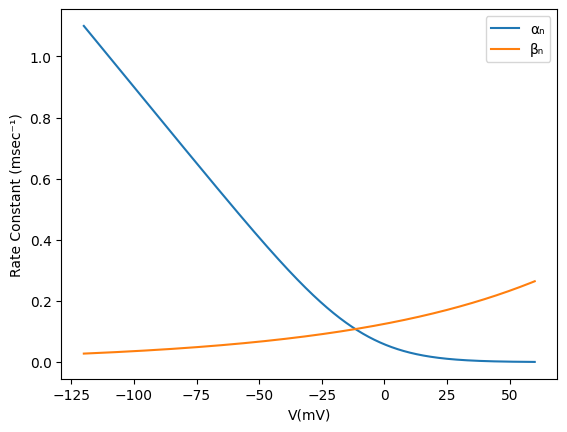

In [55]:
#FIGURE 4
plt.plot(xlist, alpha_n_ylist, label='⍺ₙ')
plt.plot(xlist, beta_n_ylist, label='βₙ')
plt.xlabel("V(mV)")
plt.ylabel("Rate Constant (msec⁻¹)")

plt.legend()
plt.show()

### Figure 5

Experimental Plot:

In [56]:
v_arr = [-59,-55,-46,-39,-33,-27-14,-2,11,23,35,44]
vclamp = h.VClamp(0.5, sec=my_cell.soma)
vclamp.dur[0] = 30  # duration of the voltage step (ms)

n_inf_e = []
m_inf_e = []
h_inf_e = []
for v in v_arr:
  #vclamp = h.VClamp(0.5, sec=my_cell.soma)
  #vclamp.dur[0] = 11  
  vclamp.amp[0] = v
  #soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
  #gk_vec=h.Vector().record(my_cell.soma(0.5).hh._ref_gk)
  n_vec = h.Vector().record(my_cell.soma(0.5).hh._ref_n)
  m_vec = h.Vector().record(my_cell.soma(0.5).hh._ref_m)
  h_vec = h.Vector().record(my_cell.soma(0.5).hh._ref_h)
  t = h.Vector().record(h._ref_t)
  h.finitialize(-65 * mV)
  h.continuerun(30 * ms)
  #gk_arr.append(gk_vec)
  n_inf_e.append(n_vec[-1])
  m_inf_e.append(m_vec[-1])
  h_inf_e.append(h_vec[-1])
  
v_arr = [-65-x for x in v_arr]

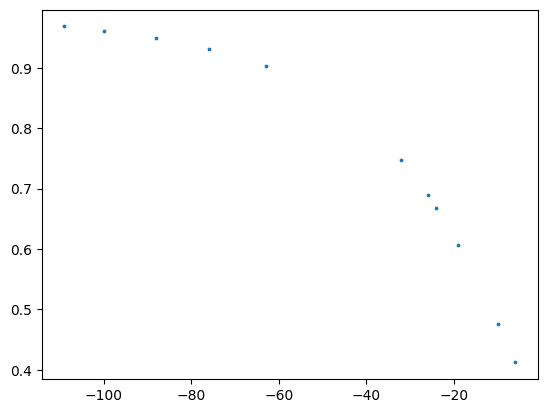

In [57]:
plt.scatter(v_arr, n_inf_e, s=3)

Theoretical plot:

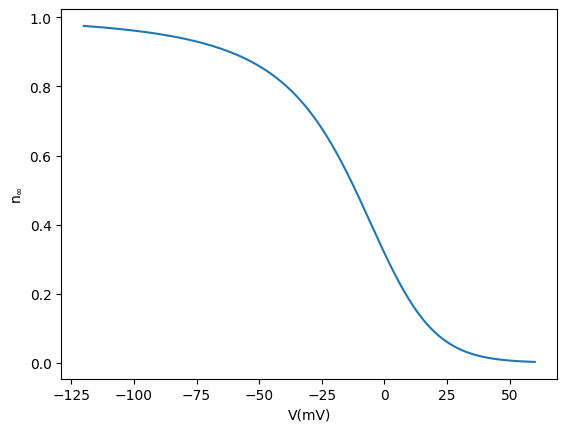

In [58]:
#FIGURE 5
plt.plot(xlist, n_inf_ylist)
plt.xlabel("V(mV)")
plt.ylabel("n$_\infty$")
plt.show()

Overlay

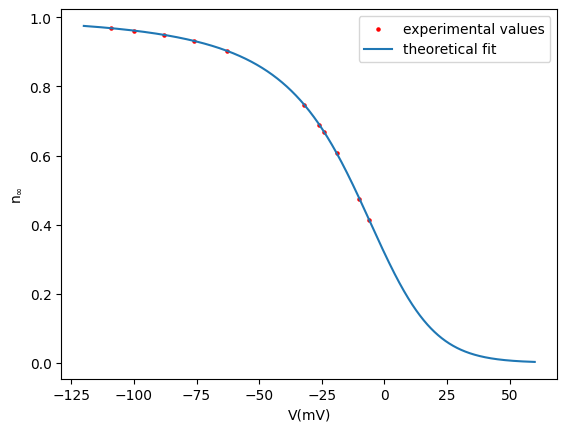

In [59]:
plt.scatter(v_arr, n_inf_e, s=5,c='r')
plt.plot(xlist, n_inf_ylist)
plt.xlabel("V(mV)")
plt.ylabel("n$_\infty$")
plt.legend(["experimental values","theoretical fit"])
plt.show()

### Figure 6

In [60]:
v_arr = [-59,-55,-46,-39,-33,-27,-14,-2,11,23,35,44]
vclamp = h.VClamp(0.5, sec=my_cell.soma)
vclamp.dur[0] = 11  # duration of the voltage step (ms)

h.finitialize(-65 * mV)
h.continuerun(11 * ms)
gk_arr = h.Vector()

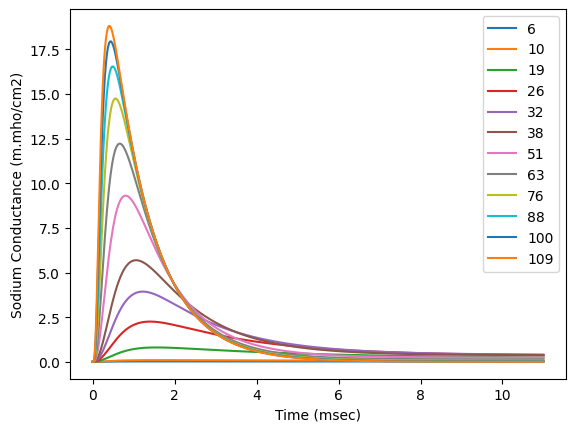

In [61]:
for v in v_arr:  
  vclamp.amp[0] = v # amplitude of the voltage step (mV)
  gk_vec=h.Vector().record(my_cell.soma(0.5).hh._ref_gna)
  t = h.Vector().record(h._ref_t)
  h.finitialize(-65 * mV)
  h.continuerun(11 * ms)
  plt.plot(t,gk_vec*435, label = v+65)
  leg = plt.legend(loc='best')
  plt.xlabel("Time (msec)")
  plt.ylabel("Sodium Conductance (m.mho/cm2)")
  #print(gk_vec)

plt.show()

Text(0, 0.5, 'Sodium conductance(m.mho/cm²')

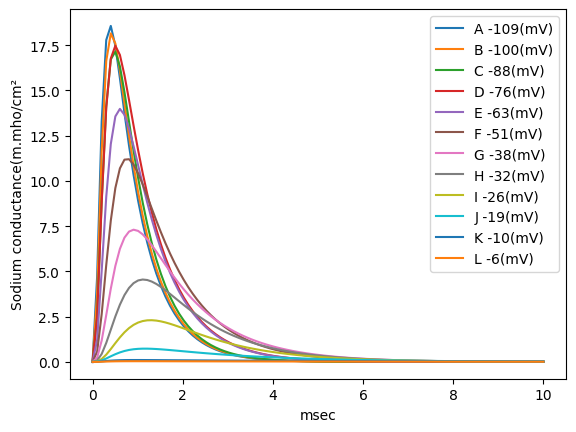

In [62]:
#FIGURE 6
xlist = np.linspace(0, 10, 100)
for x in range(12):
    GNa_ylist = []
    for val in xlist:
        GNa_ylist.append(GNa(GdNa[x], val, Tm[x], Th[x]))

    voltage = chr(x + 65) + ' ' + str(Voltage[x]) + '(mV)'
    plt.plot(xlist, GNa_ylist, label=voltage)
    plt.legend()

plt.xlabel("msec")
plt.ylabel("Sodium conductance(m.mho/cm²")

### Figure 7

In [63]:
xlist = np.linspace(-120, 10, 1800)
for val in xlist:
    alpha_m_ylist.append(alpha_m(val)[0])
    beta_m_ylist.append(beta_m(val))

    m_inf_list.append(m_inf(alpha_m(val), beta_m(val)))


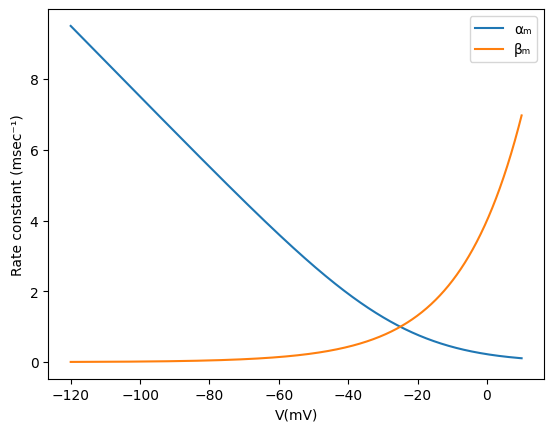

In [64]:
#FIGURE 7
plt.plot(xlist, alpha_m_ylist, label='⍺ₘ')
plt.plot(xlist, beta_m_ylist, label='βₘ')

plt.xlabel("V(mV)")
plt.ylabel("Rate constant (msec⁻¹)")
plt.legend()

### Figure 8

Ecperimental plot:

In [65]:
v_arr = [-59,-55,-46,-39,-27-14,-2,11,23,35,44]
vclamp = h.VClamp(0.5, sec=my_cell.soma)
vclamp.dur[0] = 30  # duration of the voltage step (ms)

n_inf_e = []
m_inf_e = []
h_inf_e = []
for v in v_arr:
  #vclamp = h.VClamp(0.5, sec=my_cell.soma)
  #vclamp.dur[0] = 11  
  vclamp.amp[0] = v
  #soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
  #gk_vec=h.Vector().record(my_cell.soma(0.5).hh._ref_gk)
  n_vec = h.Vector().record(my_cell.soma(0.5).hh._ref_n)
  m_vec = h.Vector().record(my_cell.soma(0.5).hh._ref_m)
  h_vec = h.Vector().record(my_cell.soma(0.5).hh._ref_h)
  t = h.Vector().record(h._ref_t)
  h.finitialize(-65 * mV)
  h.continuerun(30 * ms)
  #gk_arr.append(gk_vec)
  n_inf_e.append(n_vec[-1])
  m_inf_e.append(m_vec[-1])
  h_inf_e.append(h_vec[-1])
  
v_arr = [-65-x for x in v_arr]

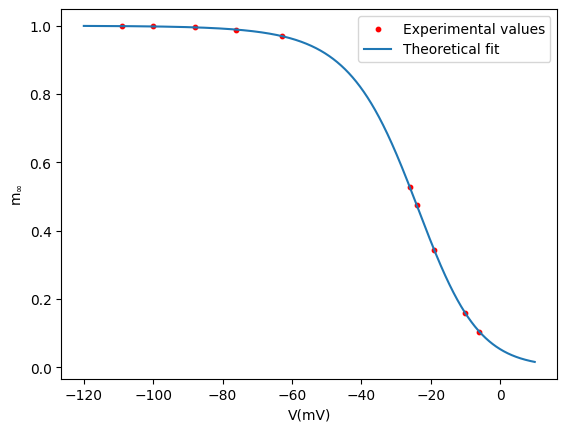

In [66]:
plt.scatter(v_arr, m_inf_e, s=10, c= 'r')
plt.plot(xlist, m_inf_list)
plt.xlabel("V(mV)")
plt.ylabel("m$_\infty$")
plt.legend(["Experimental values","Theoretical fit"],loc='best')

Text(0, 0.5, 'm$_\\infty$')

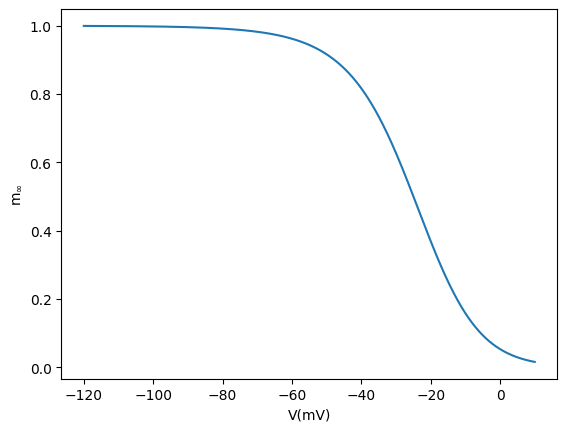

In [67]:
plt.plot(xlist, m_inf_list)
plt.xlabel("V(mV)")
plt.ylabel("m$_\infty$")

In [68]:
xlist = np.linspace(-120, 10, 1800)
for val in xlist:
    alpha_m_ylist.append(alpha_m(val)[0])
    beta_m_ylist.append(beta_m(val))

    m_inf_list.append(m_inf(alpha_m(val), beta_m(val)))

### Figure 9

In [69]:
xlist = np.linspace(-120, 40, 1800)
for val in xlist:
    alpha_h_ylist.append(alpha_h(val))
    beta_h_ylist.append(beta_h(val))


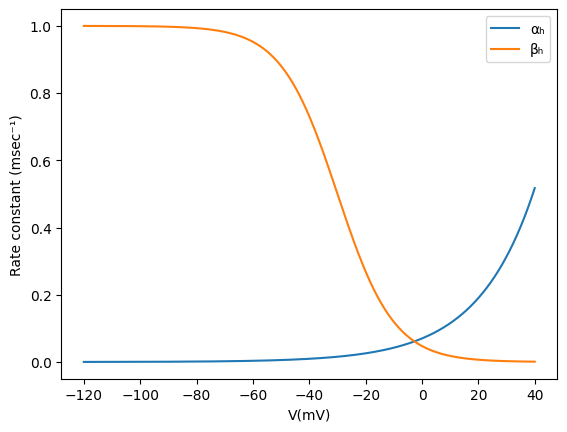

In [70]:
#FIGURE 9
plt.plot(xlist, alpha_h_ylist, label='⍺ₕ')
plt.plot(xlist, beta_h_ylist, label='βₕ')

plt.xlabel("V(mV)")
plt.ylabel("Rate constant (msec⁻¹)")
plt.legend()

### Figure 10

experimental:

In [71]:
v_arr = [-59,-55,-46,-39,-27-14,-2,11,23,35,44]
vclamp = h.VClamp(0.5, sec=my_cell.soma)
vclamp.dur[0] = 30  # duration of the voltage step (ms)

n_inf_e = []
m_inf_e = []
h_inf_e = []
for v in v_arr:
  #vclamp = h.VClamp(0.5, sec=my_cell.soma)
  #vclamp.dur[0] = 11  
  vclamp.amp[0] = v
  #soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
  #gk_vec=h.Vector().record(my_cell.soma(0.5).hh._ref_gk)
  n_vec = h.Vector().record(my_cell.soma(0.5).hh._ref_n)
  m_vec = h.Vector().record(my_cell.soma(0.5).hh._ref_m)
  h_vec = h.Vector().record(my_cell.soma(0.5).hh._ref_h)
  t = h.Vector().record(h._ref_t)
  h.finitialize(-65 * mV)
  h.continuerun(30 * ms)
  #gk_arr.append(gk_vec)
  n_inf_e.append(n_vec[-1])
  m_inf_e.append(m_vec[-1])
  h_inf_e.append(h_vec[-1])
  
v_arr = [-65-x for x in v_arr]

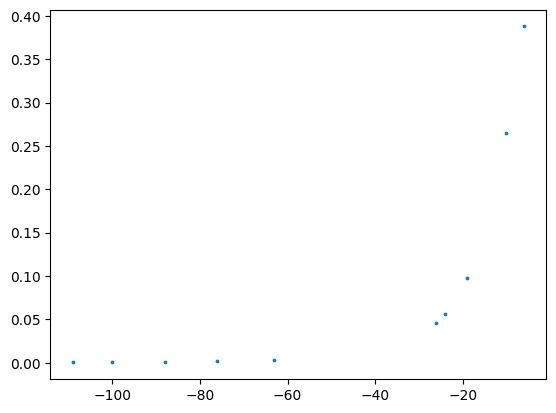

In [72]:
plt.scatter(v_arr, h_inf_e, s=3)

theoretical:

In [73]:
h_inf_list = []

Text(0, 0.5, 'V(mV)')

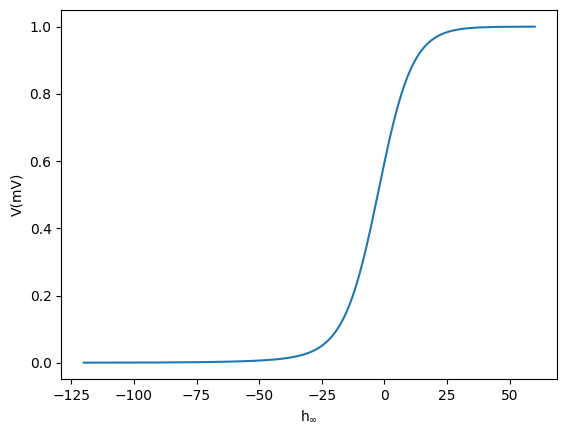

In [74]:
#FIGURE 10
xlist = np.linspace(-120, 60, 1800)
for val in xlist:
    h_inf_list.append(h_inf(alpha_h(val), beta_h(val)))

plt.plot(xlist, h_inf_list)
plt.xlabel("h$_\infty$")
plt.ylabel("V(mV)")

overlay:

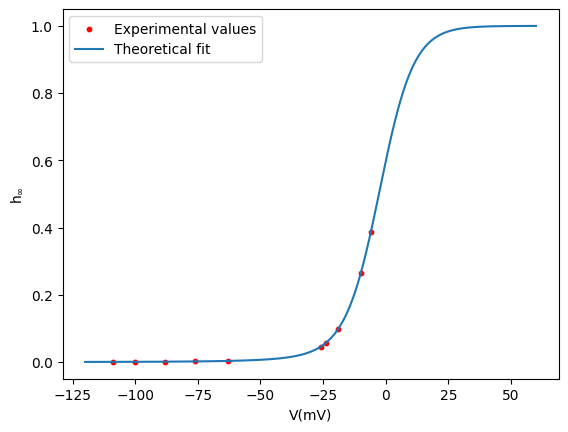

In [75]:
plt.scatter(v_arr, h_inf_e, s=10, c= 'r')
plt.plot(xlist, h_inf_list)
plt.xlabel("V(mV)")
plt.ylabel("h$_\infty$")
plt.legend(["Experimental values","Theoretical fit"],loc='best')